# Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option("max_columns", None)
from scipy.stats import chi2_contingency
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Dropout
from keras.optimizers import Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense

import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


ModuleNotFoundError: No module named 'matplotlib'

# Import Data

In [4]:
data = pd.read_csv('fashion_data_on_Instagram.csv')
data.set_index('UserId', inplace = True)
data.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171579752855683619_212070047,518.0,9840.0,541,abercrombie,High street,"beautiful, summer, fashion, love, cute, food, ...","We were born to be REAL, not to be perfect. ...",https://scontent.cdninstagram.com/t51.2885-15/...,97,0,1453883211,https://www.instagram.com/p/BBCSZPzAMIj/,0.000885,0.336438,0.741220,0.009454,0.001827,0.839466,0.890231,0.292843,0.062638,0.012164,0.931486,3.42211,0.083862,0.015089,0.000583,0.000026,0.000017,0.890586,0.009657,0.000181
1171594777274371222_176762322,7333.0,2300.0,272,abercrombie,High street,"teen, model, brunette, selfie, hollister, snap...","Gotta run, but first, let me take selfie. Me...",https://scontent.cdninstagram.com/t51.2885-15/...,94,0,1453885002,https://www.instagram.com/p/BBCVz4YJEyW/,0.003912,0.995503,0.001728,0.002125,0.002438,0.480598,0.550629,0.063139,0.126848,0.004330,0.466329,2.91971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,91,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,94,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1171508187966229230_2797323089,132.0,456.0,56,abercrombie,High street,"abercrombieandfitch, shopping, love, hollister...",#love #shopping #shoppen #hollister #abercro...,https://scontent.cdninstagram.com/t51.2885-15/...,9,1,1453874680,https://www.instagram.com/p/BBCCH1zMEru/,0.002021,0.014188,0.028351,0.418125,0.601519,0.010840,0.994191,0.332847,0.007911,0.002386,0.393063,1.45586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Clean Data

### Let's See if there are any NaNs in the data

In [5]:
hashtag = data.copy()
hashtag['Hashtags'] = data['Hashtags'].isna()
hashtag.groupby('Hashtags')['MediaCount'].count()

Hashtags
False    24606
True       146
Name: MediaCount, dtype: int64

In [6]:
Caption = data.copy()
Caption['Caption'] = data['Caption'].isna()
Caption.groupby('Caption')['MediaCount'].count()

Caption
False    24717
True        35
Name: MediaCount, dtype: int64

In [7]:
set(data['Comments '].isna())

{False}

##### So there exist NaN values in Hashtags and Captions. There are no other columns that contain NaN.

In [8]:
data.isna().groupby('Hashtags')['Followings'].count()

Hashtags
False    24606
True       146
Name: Followings, dtype: int64

##### There are 146 NaN rows in hashtags. It is possible that this is simply due to the fact that some posts do not have hashtags.

In [9]:
data.isna().groupby('Caption')['Followings'].count()

Caption
False    24717
True        35
Name: Followings, dtype: int64

##### There are 35 NaN rows in Caption

### Maybe the caption or hashtag information is missing because there is either only a caption or only hashtags....

In [10]:
hashtag_nan = list(data['Hashtags'].isna())
caption_nan = list(data['Caption'].isna())

In [11]:
count = 0
for i in range(len(hashtag_nan)):
    if hashtag_nan[i] and caption_nan[i]:
        count += 1
print('The number of times both hashtag_nan and caption_nan is true is', count)

The number of times both hashtag_nan and caption_nan is true is 18


##### So we have missing hashtag both 18/35 times that we have a missing caption. So it is not exactly correlated. Maybe we can just drop the rows that have missing caption or hashtag if we need to use these, or claim that there was not hashtag or caption for these rows.

In [12]:
chi2_contingency([[hashtag_nan.count(True), hashtag_nan.count(False)], [caption_nan.count(True), caption_nan.count(False)]])

(67.09615038449334,
 2.585828482081104e-16,
 1,
 array([[   90.5, 24661.5],
        [   90.5, 24661.5]]))

### I want to try and see if I can make brand category numeric

In [13]:
brand_category = pd.get_dummies(data['BrandCategory'])

In [14]:
brand_category.head()

,Designer,High street,Mega couture,Small couture
UserId,,,,
1171579752855683619_212070047,0,1,0,0
1171594777274371222_176762322,0,1,0,0
1171407552643586413_581125501,0,1,0,0
1171407552643586413_581125501,0,1,0,0
1171508187966229230_2797323089,0,1,0,0


In [15]:
data_new = pd.concat([data, brand_category], sort = False, axis = 1)
data_new.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171579752855683619_212070047,518.0,9840.0,541,abercrombie,High street,"beautiful, summer, fashion, love, cute, food, ...","We were born to be REAL, not to be perfect. ...",https://scontent.cdninstagram.com/t51.2885-15/...,97,0,1453883211,https://www.instagram.com/p/BBCSZPzAMIj/,0.000885,0.336438,0.741220,0.009454,0.001827,0.839466,0.890231,0.292843,0.062638,0.012164,0.931486,3.42211,0.083862,0.015089,0.000583,0.000026,0.000017,0.890586,0.009657,0.000181,0,1,0,0
1171594777274371222_176762322,7333.0,2300.0,272,abercrombie,High street,"teen, model, brunette, selfie, hollister, snap...","Gotta run, but first, let me take selfie. Me...",https://scontent.cdninstagram.com/t51.2885-15/...,94,0,1453885002,https://www.instagram.com/p/BBCVz4YJEyW/,0.003912,0.995503,0.001728,0.002125,0.002438,0.480598,0.550629,0.063139,0.126848,0.004330,0.466329,2.91971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,91,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,94,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1171508187966229230_2797323089,132.0,456.0,56,abercrombie,High street,"abercrombieandfitch, shopping, love, hollister...",#love #shopping #shoppen #hollister #abercro...,https://scontent.cdninstagram.com/t51.2885-15/...,9,1,1453874680,https://www.instagram.com/p/BBCCH1zMEru/,0.002021,0.014188,0.028351,0.418125,0.601519,0.010840,0.994191,0.332847,0.007911,0.002386,0.393063,1.45586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0


##### Now the brand category is represented in the last four columns of the dataframe with one_hot_encoding.

# Model with Numeric Data Only

First, lets try to build a model with only the numeric data. This will be easy to do and will allow us to understand whether any of these numeric factors influence the number of likes/comments a user gets. 

### Likes Model

In [16]:
X = np.array(data_new[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']])
y = np.array(data_new['Likes'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [18]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [19]:
X_train, X_test = standardize(X_train, X_test)

In [20]:
epsilon = 1e-200
y_train = np.log(y_train + epsilon)
y_test = np.log(y_test + epsilon)

Let's use a Lasso Regression model to regress based on the likes that we receive. I want to use lasso because lasso will send the unimportant variables to zero allowing us to see which features are important. 

In [21]:
lasso = Lasso(alpha = 0.1, max_iter = 10000).fit(X_train, y_train)

In [22]:
predictions = lasso.predict((X_test))
r2_score(y_test, predictions)

0.02953513081793302

Maybe ridge regression will work better?

In [23]:
ridge = Ridge(alpha = 0.1).fit(X_train, y_train)

In [24]:
predictions = ridge.predict((X_test))
r2_score(y_test, predictions)

0.028789646105978117

### Try with stratified crossvalidation

In [25]:
cv = StratifiedKFold(5)
lasso = Lasso(alpha = 0.1, max_iter = 10000)
for train, test in cv.split(X, y):
    X_train, X_test = standardize(X[train], X[test])
    epsilon = 1e-200
    y_train = np.log(y[train] + epsilon)
    y_test = np.log(y[test] + epsilon)
    
    lasso.fit(X_train, y_train)
    predictions = lasso.predict((X_test))
    print(r2_score(y_test, predictions))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.03333041980194418
0.017322227191164608
0.023494040402613048
0.006043123352006852
0.030156451036641663


In [26]:
cv = StratifiedKFold(5)
ridge = Ridge(alpha = 0.1)
for train, test in cv.split(X, y):
    X_train, X_test = standardize(X[train], X[test])
    epsilon = 1e-200
    y_train = np.log(y[train] + epsilon)
    y_test = np.log(y[test] + epsilon)
    
    ridge.fit(X_train, y_train)
    predictions = lasso.predict((X_test))
    print(r2_score(y_test, predictions))

0.03355581371362881
0.023278613663796577
0.02701250716408221
0.014130073519360353
0.030156451036641663


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


### I want to try evening out the amount of data in different categories based on the image features to reduce bias.

In [27]:
data = data_new[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor']]

In [28]:
selfie, body, marketing, product, nonfash, total = 0,0,0,0,0,0
selfiel, bodyl, marketingl, productl, nonfashl = [],[],[],[],[]
thresh = 0.75
for index, row in data.iterrows():
    if row['Selfie'] > thresh:
        selfie+=1
        selfiel.append(index)
    if row['BodySnap'] > thresh:
        body+=1
        bodyl.append(index)
    if row['Marketing'] > thresh:
        marketing+=1
        marketingl.append(index)
    if row['ProductOnly'] > thresh:
        product+=1
        productl.append(index)
    if row['NonFashion'] > thresh:
        nonfash+=1
        nonfashl.append(index)
    total+=1

print('Selfie: ', selfie/total * 100)
print('BodySnap: ', body/total * 100)
print('Marketing: ', marketing/total * 100)
print('ProductOnly: ', product/total * 100)
print('NonFashion: ', nonfash/total * 100)

Selfie:  1.3574660633484164
BodySnap:  22.551712992889463
Marketing:  5.2521008403361344
ProductOnly:  34.68810601163542
NonFashion:  7.558985132514544


### Try with the data that we increase the number of certain kinds of data

In [29]:
X = data_new[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_new[['Likes']]

In [30]:
# add some random data to even out bias
import random
selfie_lst = selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel
indices = random.sample(selfie_lst, selfie*20)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
marketing_lst = marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl
indices = random.sample(marketing_lst, marketing*5)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
nonfash_lst = nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl
indices = random.sample(nonfash_lst, nonfash*2)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])

In [31]:
selfien, bodyn, marketingn, productn, nonfashn, totaln = 0,0,0,0,0,0
thresh = 0.75
for index, row in X.iterrows():
    if row['Selfie'] > thresh:
        selfien+=1
    if row['BodySnap'] > thresh:
        bodyn+=1
    if row['Marketing'] > thresh:
        marketingn+=1
    if row['ProductOnly'] > thresh:
        productn+=1
    if row['NonFashion'] > thresh:
        nonfashn+=1
    totaln+=1

print('Selfie: ', selfien/totaln * 100)
print('BodySnap: ', bodyn/totaln * 100)
print('Marketing: ', marketingn/totaln * 100)
print('ProductOnly: ', productn/totaln * 100)
print('NonFashion: ', nonfashn/totaln * 100)

Selfie:  16.766467065868262
BodySnap:  13.425529892595762
Marketing:  19.00247124798023
ProductOnly:  20.492348636061212
NonFashion:  13.981560688147516


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [33]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [34]:
X_train, X_test = standardize(X_train, X_test)

In [35]:
epsilon = 1e-200
y_train = np.log(y_train + epsilon)
y_test = np.log(y_test + epsilon)

Let's use a Lasso Regression model to regress based on the likes that we receive. I want to use lasso because lasso will send the unimportant variables to zero allowing us to see which features are important. 

In [36]:
lasso = Lasso(alpha = 0.01, max_iter = 10000).fit(X_train, y_train)

In [37]:
predictions = lasso.predict((X_test))
r2_score(y_test, predictions)

0.03519665775982561

### Including things we know likes are dependent on 

In [38]:
X = data_new[['Followings', 'Followers', 'MediaCount','Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_new['Likes']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [40]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [41]:
X_train, X_test = standardize(X_train, X_test)

Let's use a Lasso Regression model to regress based on the likes that we receive. I want to use lasso because lasso will send the unimportant variables to zero allowing us to see which features are important. 

In [42]:
lasso = Lasso(alpha = 0.1, max_iter = 10000).fit(X_train, y_train)

In [43]:
predictions = lasso.predict((X_test))
r2_score(y_test, predictions)

0.2984377062815087

In [44]:
coeffs = lasso.coef_
coeffs

array([-6.58234530e+00,  8.70789035e+02, -3.76071298e+01,  6.05677651e+00,
        6.63928586e+00, -1.33474595e+01, -1.61954574e+01, -4.38579844e+00,
        4.72489489e+00, -1.37963918e+01,  5.53602077e+00, -7.13978028e+00,
        2.45144628e+01, -1.42085498e+01, -8.85406752e-01, -1.22365074e+00,
       -3.41366990e-01, -2.22404504e+00, -8.50311206e-01, -2.01326174e+00,
        4.93909402e+00,  1.27575539e+00,  3.63064879e-02, -3.79419350e+00,
        6.67870337e+00, -1.01542954e-01,  0.00000000e+00])

Maybe ridge regression will work better?

In [45]:
ridge = Ridge(alpha = 0.1).fit(X_train, y_train)

In [46]:
predictions = ridge.predict((X_test))
r2_score(y_test, predictions)

0.2984484171726812

In [47]:
coeffs = ridge.coef_
coeffs_log = np.log(np.absolute(coeffs))
coeffs_log

array([ 1.8926923 ,  6.76951145,  3.62929684,  1.79911168,  1.79881345,
        2.64119074,  2.82765942,  1.58277161,  1.72427926,  2.63486184,
        1.75613061,  2.0379585 ,  3.20342555,  2.67783815, -0.01057083,
        0.27565183, -0.80973737,  0.82205789, -0.03075536,  0.74162377,
        1.59948903,  0.32644277, -1.82368402,  1.50962839,  1.81650726,
       -0.64343496, -0.75360616])

# Weights Plot

In [213]:
input_columns = np.array(X_train.columns).reshape(-1,1)
coeffs_arr = coeffs_log.reshape(-1,1)

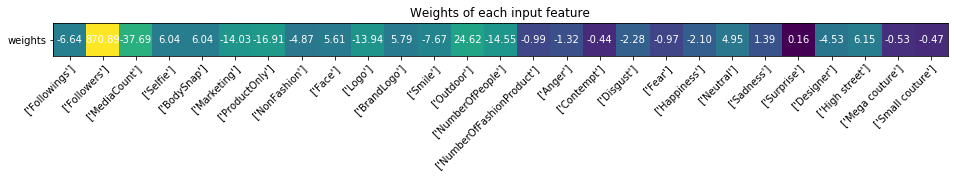

In [220]:
fig, ax = plt.subplots()
im = ax.imshow(coeffs_arr.transpose())

# We want to show all ticks...
ax.set_xticks(np.arange(len(coeffs_arr)))
ax.set_yticks(np.arange(1))
# ... and label them with the respective list entries
ax.set_xticklabels(input_columns)
ax.set_yticklabels(["weights"])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(coeffs)):
        text = ax.text(i, 0, str.format('{0:.2f}', coeffs[i]),
                       ha="center", va="center", color="w")

ax.set_title("Weights of each input feature")
fig.tight_layout()
fig.set_size_inches(15, 10.5)
fig.savefig('weights.png', dpi=100)
plt.show()

# Try a Deep Learning Model

In [48]:
def our_model():
    model = Sequential()

    model.add(Dense(units=64, activation='relu', input_dim = 27, name="input_layer"))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

In [158]:
estimator = KerasRegressor(build_fn=our_model, epochs=100, batch_size=5, verbose=1)

In [159]:
estimator.fit(X_train, y_train)

Epoch 1/100
16583/16583 [==============================] - 3s 165us/step - loss: 477390.0326 - accuracy: 0.0087
Epoch 2/100
16583/16583 [==============================] - 3s 154us/step - loss: 232140.9378 - accuracy: 0.0107
Epoch 3/100
16583/16583 [==============================] - 3s 156us/step - loss: 222641.4443 - accuracy: 0.0100
Epoch 4/100
16583/16583 [==============================] - 3s 156us/step - loss: 205907.0589 - accuracy: 0.0090
Epoch 5/100
16583/16583 [==============================] - 3s 155us/step - loss: 232413.2804 - accuracy: 0.0105
Epoch 6/100
16583/16583 [==============================] - 3s 152us/step - loss: 186880.1543 - accuracy: 0.0101
Epoch 7/100
16583/16583 [==============================] - 3s 152us/step - loss: 175330.9911 - accuracy: 0.0106
Epoch 8/100
16583/16583 [==============================] - 3s 155us/step - loss: 228185.9071 - accuracy: 0.0085
Epoch 9/100
16583/16583 [==============================] - 3s 154us/step - loss: 139227.9541 - accuracy:

In [165]:
estimator.model.get_layer(name="input_layer").get_weights()[0]

array([[ 0.62610762, -0.47258985, -0.47242604, ..., -0.52252514,
        -0.43302569, -0.17991141],
       [ 0.04539355,  0.04816135,  0.21393841, ...,  0.10186353,
         0.1013034 ,  0.05062443],
       [-1.74212486, -1.28758557, -0.59692449, ..., -1.31594244,
        -2.87581771, -1.92310017],
       ...,
       [ 0.21116172,  0.05719854, -0.77485088, ..., -0.48421663,
        -0.56360772,  0.24981904],
       [ 0.75079358,  0.40102121, -0.28292818, ..., -0.41612798,
         0.00836689,  0.17925992],
       [ 0.89650845,  0.47832294, -0.12195803, ...,  0.27284904,
         0.27898943,  0.74929249]])

In [160]:
preds = estimator.predict(X_test)

8169/8169 [==============================] - 0s 37us/step


In [161]:
r2_score(y_test, preds)

0.3530763029878393

Maybe we need to investigate how the input space was normalized. Maybe the categorical variables that are represented by 1's and 0's at the end of the dataframe need to be normalized?

After log normalization of the likes we have worse results on this model.

Average loss value for Keras deep learning model based on just numeric values and predicting likes is 154K.

Maybe try using likes / followers?

# Likes to Follower Ratio

First check if there are any null likes or follower entries

In [49]:
data_new['Likes'].isnull().any() 

False

In [50]:
data_new['Followers'].isnull().any()

False

In [51]:
data_ver2 = pd.concat([data_new, brand_category], sort = False, axis = 1)
data_ver2['LikesToFollowers'] = data_ver2['Likes'] / data_ver2['Followers']
data_ver2.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture,Designer,High street,Mega couture,Small couture,LikesToFollowers
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171579752855683619_212070047,518.0,9840.0,541,abercrombie,High street,"beautiful, summer, fashion, love, cute, food, ...","We were born to be REAL, not to be perfect. ...",https://scontent.cdninstagram.com/t51.2885-15/...,97,0,1453883211,https://www.instagram.com/p/BBCSZPzAMIj/,0.000885,0.336438,0.741220,0.009454,0.001827,0.839466,0.890231,0.292843,0.062638,0.012164,0.931486,3.42211,0.083862,0.015089,0.000583,0.000026,0.000017,0.890586,0.009657,0.000181,0,1,0,0,0,1,0,0,0.009858
1171594777274371222_176762322,7333.0,2300.0,272,abercrombie,High street,"teen, model, brunette, selfie, hollister, snap...","Gotta run, but first, let me take selfie. Me...",https://scontent.cdninstagram.com/t51.2885-15/...,94,0,1453885002,https://www.instagram.com/p/BBCVz4YJEyW/,0.003912,0.995503,0.001728,0.002125,0.002438,0.480598,0.550629,0.063139,0.126848,0.004330,0.466329,2.91971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,0.040870
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,91,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,0.150413
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,94,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,0.155372
1171508187966229230_2797323089,132.0,456.0,56,abercrombie,High street,"abercrombieandfitch, shopping, love, hollister...",#love #shopping #shoppen #hollister #abercro...,https://scontent.cdninstagram.com/t51.2885-15/...,9,1,1453874680,https://www.instagram.com/p/BBCCH1zMEru/,0.002021,0.014188,0.028351,0.418125,0.601519,0.010840,0.994191,0.332847,0.007911,0.002386,0.393063,1.45586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,0.019737


In [52]:
data_ver2.replace([np.inf, -np.inf], np.nan, inplace = True);

In [53]:
data_test = data_ver2[data_ver2['LikesToFollowers'].isnull()]
data_test.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture,Designer,High street,Mega couture,Small couture,LikesToFollowers
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171240019544303946_23457617,0.0,0.0,1,acnestudios,Designer,"shop, anndemeulemeester, style, acnestudios, t...",Black? Or dark black... @00000 #totokaelo #l...,https://scontent.cdninstagram.com/t51.2885-15/...,37,0,1453842712,https://www.instagram.com/p/BBBFJefqOlK/,0.000158,0.001617,0.007038,0.997941,0.001827,0.000604,0.099600,0.073979,0.000380,0.001582,0.192986,3.91808,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0,0,0,1,0,0,0,NaN
1171142669094830425_252313279,36.0,0.0,0,acnestudios,Designer,"acnestudios, collegeface",#collegeface in college\U0001f610 #acnestudios,https://scontent.cdninstagram.com/t51.2885-15/...,18,1,1453831107,https://www.instagram.com/p/BBAvA10s0FZ/,0.870760,0.200230,0.063385,0.003886,0.016565,0.991469,0.052578,0.024295,0.510374,0.032716,1.752410,2.34389,3.308620e-04,0.003890,4.890000e-05,4.975480e-04,0.000018,0.829768,0.150697,0.014749,1,0,0,0,1,0,0,0,NaN
1171278619918133139_23638768,0.0,0.0,0,acnestudios,Designer,NaN,1.26 | \u2603 Cc: \U0001f4f7 @00000,https://scontent.cdninstagram.com/t51.2885-15/...,136,9,1453847313,https://www.instagram.com/p/BBBN7L5OueT/,0.008489,0.907810,0.258318,0.002872,0.000588,0.974532,0.053198,0.020144,0.215500,0.081668,1.268000,5.73313,3.104320e-04,0.000025,1.300000e-05,3.810000e-06,0.011196,0.955701,0.032682,0.000069,1,0,0,0,1,0,0,0,NaN
1170503373243750859_2795691477,0.0,0.0,1,acnestudios,Designer,"sorpreseinmacchina, acnestudios, withstyle, ga...",#jackolsen #jauria #withstyle #migraineprobl...,https://scontent.cdninstagram.com/t51.2885-15/...,10,0,1453754897,https://www.instagram.com/p/BA-dp3KlxnL/,0.375648,0.528273,0.055469,0.001185,0.009081,0.996861,0.134891,0.024669,0.513444,0.315825,1.413850,4.22136,2.080000e-07,0.000181,8.390000e-07,4.160000e-09,0.979905,0.019908,0.000003,0.000001,1,0,0,0,1,0,0,0,NaN
1170007750938083500_2120361935,39.0,0.0,0,alexanderwang,Designer,"jimmychoo, slimthickwithyourcuteass, alexander...","u\""\""I swear she's so perfect she makes me s...",https://scontent.cdninstagram.com/t51.2885-15/...,74,0,1453695814,https://www.instagram.com/p/BA8s9m7HkCs/,0.002184,0.999626,0.000747,0.000168,0.000336,0.771275,0.026620,0.001609,0.331313,0.013736,0.667217,4.49539,8.573980e-04,0.001655,4.457260e-04,2.339453e-03,0.008483,0.939227,0.021567,0.025426,1,0,0,0,1,0,0,0,NaN


Drop rows where LikesToFollowers is NAN. Likes and Followers count at both 0.

In [54]:
data_ver2 = data_ver2.dropna()

In [55]:
data_ver2['LikesToFollowers'].isnull().any()

False

In [56]:
X = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_ver2['LikesToFollowers']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [58]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [59]:
X_train, X_test = standardize(X_train, X_test)

In [60]:
epsilon = 1e-200
y_train = np.log(y_train+epsilon)
y_test = np.log(y_test+epsilon)

In [61]:
import keras
keras.backend.floatx()
keras.backend.set_floatx('float64')
keras.backend.floatx()

'float64'

In [62]:
def our_model_ver2():
    model = Sequential()
    model.add(Dense(units=128, input_dim = 28))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Dense(units=64, activation = 'tanh'))
    
    model.add(Dense(units=1))
    #opt = Adadelta(clipnorm=0.3)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

estimator = KerasRegressor(build_fn=our_model_ver2, epochs=100, batch_size=500, verbose=1)

# kfold = KFold(n_splits=5)
# results = cross_val_score(estimator, X_train, y_train, cv=kfold)
# print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [128]:
estimator.fit(X_train, y_train)

Epoch 1/100
22088/22088 [==============================] - 0s 22us/step - loss: 3500.0212 - accuracy: 0.0000e+00
Epoch 2/100
22088/22088 [==============================] - 0s 13us/step - loss: 3450.4761 - accuracy: 0.0000e+00
Epoch 3/100
22088/22088 [==============================] - 0s 14us/step - loss: 3435.0113 - accuracy: 0.0000e+00
Epoch 4/100
22088/22088 [==============================] - 0s 13us/step - loss: 3419.8970 - accuracy: 0.0000e+00
Epoch 5/100
22088/22088 [==============================] - 0s 16us/step - loss: 3407.5999 - accuracy: 0.0000e+00
Epoch 6/100
22088/22088 [==============================] - 0s 16us/step - loss: 3397.9128 - accuracy: 0.0000e+00
Epoch 7/100
22088/22088 [==============================] - 0s 15us/step - loss: 3393.1575 - accuracy: 0.0000e+00
Epoch 8/100
22088/22088 [==============================] - 0s 14us/step - loss: 3385.4892 - accuracy: 0.0000e+00
Epoch 9/100
22088/22088 [==============================] - 0s 15us/step - loss: 3381.8423 - accu

In [129]:
preds = estimator.predict(X_test)

2455/2455 [==============================] - 0s 14us/step


In [130]:
r2_score(y_test, preds)

0.06785502293328327

When using log normalization of likes/followers we got 0.036 and when we did log normalization of just likes we got 0.035. Additionally, reducing the amount of test data and the batch size improves the results further to 0.0856.

# Try modifying bias and running the deep learning likes to followers model

In [106]:
data = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor']]

In [107]:
selfie, body, marketing, product, nonfash, total = 0,0,0,0,0,0
selfiel, bodyl, marketingl, productl, nonfashl = [],[],[],[],[]
thresh = 0.75
for index, row in data.iterrows():
    if row['Selfie'] > thresh:
        selfie+=1
        selfiel.append(index)
    if row['BodySnap'] > thresh:
        body+=1
        bodyl.append(index)
    if row['Marketing'] > thresh:
        marketing+=1
        marketingl.append(index)
    if row['ProductOnly'] > thresh:
        product+=1
        productl.append(index)
    if row['NonFashion'] > thresh:
        nonfash+=1
        nonfashl.append(index)
    total+=1

print('Selfie: ', selfie/total * 100)
print('BodySnap: ', body/total * 100)
print('Marketing: ', marketing/total * 100)
print('ProductOnly: ', product/total * 100)
print('NonFashion: ', nonfash/total * 100)

Selfie:  1.3486533838569041
BodySnap:  22.450393187466894
Marketing:  5.272379089760828
ProductOnly:  34.82459357046816
NonFashion:  7.554088742207554


In [108]:
X = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_ver2[['LikesToFollowers']]

In [109]:
# add some random selfie data
import random
selfie_lst = selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel
indices = random.sample(selfie_lst, selfie*20)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
marketing_lst = marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl
indices = random.sample(marketing_lst, marketing*5)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
nonfash_lst = nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl
indices = random.sample(nonfash_lst, nonfash*2)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [111]:
print(X_train.shape)

(37494, 28)


In [68]:
def standardize(train, test):


    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test

In [69]:
X_train, X_test = standardize(X_train, X_test)

In [70]:
epsilon = 1e-200
y_train = np.log(y_train+epsilon)
y_test = np.log(y_test+epsilon)

In [71]:
def our_model_ver2():
    model = Sequential()
    model.add(Dense(units=128, input_dim = 28))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Dense(units=64, activation = 'tanh'))
    
    model.add(Dense(units=1))
    #opt = Adadelta(clipnorm=0.3)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

estimator = KerasRegressor(build_fn=our_model_ver2, epochs=100, batch_size=500, verbose=1)
print(X_train.shape)
print(y_train.shape)

(37498, 28)
(37498, 1)


In [140]:
estimator.fit(X_train, y_train)

Epoch 1/100
37467/37467 [==============================] - 1s 17us/step - loss: 3510.2947 - accuracy: 0.0000e+00
Epoch 2/100
37467/37467 [==============================] - 0s 13us/step - loss: 3457.0018 - accuracy: 0.0000e+00
Epoch 3/100
37467/37467 [==============================] - 1s 15us/step - loss: 3426.1239 - accuracy: 0.0000e+00
Epoch 4/100
37467/37467 [==============================] - 0s 13us/step - loss: 3402.9896 - accuracy: 0.0000e+00
Epoch 5/100
37467/37467 [==============================] - 1s 15us/step - loss: 3383.8745 - accuracy: 0.0000e+00
Epoch 6/100
37467/37467 [==============================] - 0s 13us/step - loss: 3367.7126 - accuracy: 0.0000e+00
Epoch 7/100
37467/37467 [==============================] - 1s 14us/step - loss: 3354.9676 - accuracy: 0.0000e+00
Epoch 8/100
37467/37467 [==============================] - 1s 14us/step - loss: 3340.2951 - accuracy: 0.0000e+00
Epoch 9/100
37467/37467 [==============================] - 1s 14us/step - loss: 3333.4907 - accu

In [93]:
preds = estimator.predict(X_test)
print(preds)

4167/4167 [==============================] - 0s 8us/step
[-3.14612836 -4.01980745 -9.01068471 ... -9.23297095 -4.0608833
 -3.2838589 ]


In [94]:
r2_score(y_test, preds)

0.193331020143496

# Try Engagement (Likes + Comments)

In [72]:
data_new['Comments ']

UserId
1171579752855683619_212070047     0
1171594777274371222_176762322     0
1171407552643586413_581125501     3
1171407552643586413_581125501     3
1171508187966229230_2797323089    1
                                 ..
1171575731978099465_389885373     0
1171566570370586806_253427645     1
1171566525099211846_1433754542    0
1171566525099211846_1433754542    0
1171565778125281443_253427645     1
Name: Comments , Length: 24752, dtype: int64

In [73]:
data_ver3 = pd.concat([data_new, brand_category], sort = False, axis = 1)
data_ver3['Engagement'] = data_ver3['Likes'] + data_ver3['Comments ']
data_ver3['EngagementToFollowers'] = data_ver3['Engagement'] / data_ver3['Followers']
# data_ver3.dropna()
data_ver3.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture,Designer,High street,Mega couture,Small couture,Engagement,EngagementToFollowers
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171579752855683619_212070047,518.0,9840.0,541,abercrombie,High street,"beautiful, summer, fashion, love, cute, food, ...","We were born to be REAL, not to be perfect. ...",https://scontent.cdninstagram.com/t51.2885-15/...,97,0,1453883211,https://www.instagram.com/p/BBCSZPzAMIj/,0.000885,0.336438,0.741220,0.009454,0.001827,0.839466,0.890231,0.292843,0.062638,0.012164,0.931486,3.42211,0.083862,0.015089,0.000583,0.000026,0.000017,0.890586,0.009657,0.000181,0,1,0,0,0,1,0,0,97,0.009858
1171594777274371222_176762322,7333.0,2300.0,272,abercrombie,High street,"teen, model, brunette, selfie, hollister, snap...","Gotta run, but first, let me take selfie. Me...",https://scontent.cdninstagram.com/t51.2885-15/...,94,0,1453885002,https://www.instagram.com/p/BBCVz4YJEyW/,0.003912,0.995503,0.001728,0.002125,0.002438,0.480598,0.550629,0.063139,0.126848,0.004330,0.466329,2.91971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,94,0.040870
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,91,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,94,0.155372
1171407552643586413_581125501,131.0,605.0,106,abercrombie,High street,"alexandani, cute, llbean, beanboots, anthropol...",dress to impress\U0001f457,https://scontent.cdninstagram.com/t51.2885-15/...,94,3,1453862683,https://www.instagram.com/p/BBBrPZ2h9lt/,0.015774,0.963880,0.025719,0.027023,0.003409,0.283399,0.095724,0.037635,0.107896,0.712017,1.116500,4.69096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,97,0.160331
1171508187966229230_2797323089,132.0,456.0,56,abercrombie,High street,"abercrombieandfitch, shopping, love, hollister...",#love #shopping #shoppen #hollister #abercro...,https://scontent.cdninstagram.com/t51.2885-15/...,9,1,1453874680,https://www.instagram.com/p/BBCCH1zMEru/,0.002021,0.014188,0.028351,0.418125,0.601519,0.010840,0.994191,0.332847,0.007911,0.002386,0.393063,1.45586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,10,0.021930


In [74]:
data_ver3.replace([np.inf, -np.inf], np.nan, inplace = True);

In [75]:
data_test = data_ver3[data_ver3['EngagementToFollowers'].isnull()]
data_test.head()

,Followings,Followers,MediaCount,BrandName,BrandCategory,Hashtags,Caption,ImgURL,Likes,Comments,CreationTime,Link,Selfie,BodySnap,Marketing,ProductOnly,NonFashion,Face,Logo,BrandLogo,Smile,Outdoor,NumberOfPeople,NumberOfFashionProduct,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise,Designer,High street,Mega couture,Small couture,Designer,High street,Mega couture,Small couture,Engagement,EngagementToFollowers
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1171240019544303946_23457617,0.0,0.0,1,acnestudios,Designer,"shop, anndemeulemeester, style, acnestudios, t...",Black? Or dark black... @00000 #totokaelo #l...,https://scontent.cdninstagram.com/t51.2885-15/...,37,0,1453842712,https://www.instagram.com/p/BBBFJefqOlK/,0.000158,0.001617,0.007038,0.997941,0.001827,0.000604,0.099600,0.073979,0.000380,0.001582,0.192986,3.91808,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1,0,0,0,1,0,0,0,37,NaN
1171142669094830425_252313279,36.0,0.0,0,acnestudios,Designer,"acnestudios, collegeface",#collegeface in college\U0001f610 #acnestudios,https://scontent.cdninstagram.com/t51.2885-15/...,18,1,1453831107,https://www.instagram.com/p/BBAvA10s0FZ/,0.870760,0.200230,0.063385,0.003886,0.016565,0.991469,0.052578,0.024295,0.510374,0.032716,1.752410,2.34389,3.308620e-04,0.003890,4.890000e-05,4.975480e-04,0.000018,0.829768,0.150697,0.014749,1,0,0,0,1,0,0,0,19,NaN
1171278619918133139_23638768,0.0,0.0,0,acnestudios,Designer,NaN,1.26 | \u2603 Cc: \U0001f4f7 @00000,https://scontent.cdninstagram.com/t51.2885-15/...,136,9,1453847313,https://www.instagram.com/p/BBBN7L5OueT/,0.008489,0.907810,0.258318,0.002872,0.000588,0.974532,0.053198,0.020144,0.215500,0.081668,1.268000,5.73313,3.104320e-04,0.000025,1.300000e-05,3.810000e-06,0.011196,0.955701,0.032682,0.000069,1,0,0,0,1,0,0,0,145,NaN
1170503373243750859_2795691477,0.0,0.0,1,acnestudios,Designer,"sorpreseinmacchina, acnestudios, withstyle, ga...",#jackolsen #jauria #withstyle #migraineprobl...,https://scontent.cdninstagram.com/t51.2885-15/...,10,0,1453754897,https://www.instagram.com/p/BA-dp3KlxnL/,0.375648,0.528273,0.055469,0.001185,0.009081,0.996861,0.134891,0.024669,0.513444,0.315825,1.413850,4.22136,2.080000e-07,0.000181,8.390000e-07,4.160000e-09,0.979905,0.019908,0.000003,0.000001,1,0,0,0,1,0,0,0,10,NaN
1170007750938083500_2120361935,39.0,0.0,0,alexanderwang,Designer,"jimmychoo, slimthickwithyourcuteass, alexander...","u\""\""I swear she's so perfect she makes me s...",https://scontent.cdninstagram.com/t51.2885-15/...,74,0,1453695814,https://www.instagram.com/p/BA8s9m7HkCs/,0.002184,0.999626,0.000747,0.000168,0.000336,0.771275,0.026620,0.001609,0.331313,0.013736,0.667217,4.49539,8.573980e-04,0.001655,4.457260e-04,2.339453e-03,0.008483,0.939227,0.021567,0.025426,1,0,0,0,1,0,0,0,74,NaN


In [76]:
data_ver3 = data_ver3.dropna()

In [77]:
data_ver3['EngagementToFollowers'].isnull().any()

False

### Include the bias modification

In [130]:
data = data_ver3[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor']]

In [131]:
selfie, body, marketing, product, nonfash, total = 0,0,0,0,0,0
selfiel, bodyl, marketingl, productl, nonfashl = [],[],[],[],[]
thresh = 0.75
for index, row in data.iterrows():
    if row['Selfie'] > thresh:
        selfie+=1
        selfiel.append(index)
    if row['BodySnap'] > thresh:
        body+=1
        bodyl.append(index)
    if row['Marketing'] > thresh:
        marketing+=1
        marketingl.append(index)
    if row['ProductOnly'] > thresh:
        product+=1
        productl.append(index)
    if row['NonFashion'] > thresh:
        nonfash+=1
        nonfashl.append(index)
    total+=1

print('Selfie: ', selfie/total * 100)
print('BodySnap: ', body/total * 100)
print('Marketing: ', marketing/total * 100)
print('ProductOnly: ', product/total * 100)
print('NonFashion: ', nonfash/total * 100)

Selfie:  1.3486533838569041
BodySnap:  22.450393187466894
Marketing:  5.272379089760828
ProductOnly:  34.82459357046816
NonFashion:  7.554088742207554


In [132]:
X = data_ver3[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]
y = data_ver3[['EngagementToFollowers']]

In [133]:
# add some random selfie data
import random
selfie_lst = selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel
indices = random.sample(selfie_lst, selfie*20)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
marketing_lst = marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl
indices = random.sample(marketing_lst, marketing*5)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])
nonfash_lst = nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl
indices = random.sample(nonfash_lst, nonfash*2)
X = X.append(X.loc[indices])
y = y.append(y.loc[indices])

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [83]:
X_train, X_test = standardize(X_train, X_test) # standardize

In [84]:
epsilon = 1e-200
y_train = np.log(y_train+epsilon)
y_test = np.log(y_test+epsilon)

In [85]:
def our_model_ver2():
    model = Sequential()
    model.add(Dense(units=128, input_dim = 28))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Dense(units=64, activation = 'tanh'))
    
    model.add(Dense(units=1))
    #opt = Adadelta(clipnorm=0.3)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

estimator = KerasRegressor(build_fn=our_model_ver2, epochs=100, batch_size=500, verbose=1)
print(X_train.shape)
print(y_train.shape) # run v2 of model

(37496, 28)
(37496, 1)


In [109]:
estimator.fit(X_train, y_train)

Epoch 1/100
37503/37503 [==============================] - 1s 18us/step - loss: 3076.8808 - accuracy: 0.0000e+00
Epoch 2/100
37503/37503 [==============================] - 1s 15us/step - loss: 3027.3511 - accuracy: 0.0000e+00
Epoch 3/100
37503/37503 [==============================] - 1s 14us/step - loss: 3002.2000 - accuracy: 0.0000e+00
Epoch 4/100
37503/37503 [==============================] - 1s 14us/step - loss: 2984.6451 - accuracy: 0.0000e+00
Epoch 5/100
37503/37503 [==============================] - 1s 16us/step - loss: 2970.7449 - accuracy: 0.0000e+00
Epoch 6/100
37503/37503 [==============================] - 1s 14us/step - loss: 2960.3286 - accuracy: 0.0000e+00
Epoch 7/100
37503/37503 [==============================] - 1s 14us/step - loss: 2949.0766 - accuracy: 0.0000e+00
Epoch 8/100
37503/37503 [==============================] - 1s 14us/step - loss: 2937.9159 - accuracy: 0.0000e+00
Epoch 9/100
37503/37503 [==============================] - 1s 15us/step - loss: 2926.7599 - accu

In [110]:
preds = estimator.predict(X_test)
print(preds)

4168/4168 [==============================] - 0s 8us/step
[ -4.5170383   -4.5170383  -37.32794927 ...  -4.55546213  -4.88157036
 -25.79572353]


In [111]:
r2_score(y_test, preds) # score for engagement to followers

0.18683654565065078

only a slight improvement from LikesToFollowers deep learning model

### ** engagement to bins **

In [113]:
data = pd.read_csv('fashion_data_on_Instagram.csv')
data.set_index('UserId', inplace = True)
data.head()

data_new = pd.concat([data, brand_category], sort = False, axis = 1)
data_new.head()

data_ver2 = data_new

data_ver2 = data_ver2.dropna()
# print(data_ver2.isnull().any())

data_likecat = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor']]
print(data_likecat.shape)



(24589, 10)


In [145]:
selfie, body, marketing, product, nonfash, total = 0,0,0,0,0,0
selfiel, bodyl, marketingl, productl, nonfashl = [],[],[],[],[]
thresh = 0.75
for index, row in data_ver2.iterrows():
    if row['Selfie'] > thresh:
        selfie+=1
        selfiel.append(index)
    if row['BodySnap'] > thresh:
        body+=1
        bodyl.append(index)
    if row['Marketing'] > thresh:
        marketing+=1
        marketingl.append(index)
    if row['ProductOnly'] > thresh:
        product+=1
        productl.append(index)
    if row['NonFashion'] > thresh:
        nonfash+=1
        nonfashl.append(index)
    total+=1

print('Selfie: ', selfie/total * 100)
print('BodySnap: ', body/total * 100)
print('Marketing: ', marketing/total * 100)
print('ProductOnly: ', product/total * 100)
print('NonFashion: ', nonfash/total * 100)

Selfie:  1.3542641018341535
BodySnap:  22.440928870633208
Marketing:  5.270649477408598
ProductOnly:  34.80418073122128
NonFashion:  7.556224327951523


#### Likes categorical

In [153]:
X_cat = data_ver2[['Selfie', 'BodySnap', 'Marketing', 'ProductOnly', 'NonFashion',
       'Face', 'Logo', 'BrandLogo', 'Smile', 'Outdoor', 'NumberOfPeople',
       'NumberOfFashionProduct', 'Anger', 'Contempt', 'Disgust', 'Fear',
       'Happiness', 'Neutral', 'Sadness', 'Surprise', 'Designer',
       'High street', 'Mega couture', 'Small couture']]

print(X_cat.shape)

likes = data_ver2[['Likes']]
print(likes.shape)

est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
est.fit(likes)
# y_cat = est.transform(likes)

data_ver2['Likes_cat'] = est.transform(likes)

# y_cat = pd.DataFrame(y_likes_cat)
y_cat = data_ver2[['Likes_cat']]


print(y_cat.shape)
print(y_cat)

# data_ver2[['Likes_cat']].head()
# data_ver2.head()

(24589, 24)
(24589, 1)
(24589, 1)
                                Likes_cat
UserId                                   
1171579752855683619_212070047         3.0
1171594777274371222_176762322         3.0
1171407552643586413_581125501         3.0
1171407552643586413_581125501         3.0
1171508187966229230_2797323089        1.0
...                                   ...
1171575731978099465_389885373         0.0
1171566570370586806_253427645         0.0
1171566525099211846_1433754542        0.0
1171566525099211846_1433754542        0.0
1171565778125281443_253427645         0.0

[24589 rows x 1 columns]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [154]:
print(y_cat.isnull().any())

Likes_cat    False
dtype: bool


In [155]:
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))
print(X_cat.shape)
print(y_cat.shape)
print(type(X_cat))
print(type(y_cat))

(41698, 28)
(41698, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(24589, 24)
(24589, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [161]:
# add some random selfie data
import random
selfie_lst = selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel+selfiel
indices = random.sample(selfie_lst, selfie*20)
X_cat = X_cat.append(X_cat.loc[indices])
y_cat = y_cat.append(y_cat.loc[indices])
marketing_lst = marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl+marketingl
indices = random.sample(marketing_lst, marketing*5)
X_cat = X_cat.append(X_cat.loc[indices])
y_cat = y_cat.append(y_cat.loc[indices])
nonfash_lst = nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl+nonfashl
indices = random.sample(nonfash_lst, nonfash*2)
X_cat = X_cat.append(X_cat.loc[indices])
y_cat = y_cat.append(y_cat.loc[indices])

In [166]:

def standardize(train, test):
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001

    X_train = (train - mean) / std
    X_test = (test - mean) /std
    return X_train, X_test


X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat\
            , y_cat, test_size=0.1, random_state=42)

X_train_cat, X_test_cat = standardize(X_train_cat, X_test_cat)
print(X_train_cat.shape)
print(y_train_cat.shape)

(212956, 24)
(212956, 1)


In [167]:
def our_model_likecat():
    import keras
    model = Sequential()
    model.add(Dense(units=128, input_dim = 24))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))

    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.25))
    
    model.add(Dense(units=64, activation = 'tanh'))
    
    model.add(Dense(units=4, activation='softmax'))

    #opt = Adadelta(clipnorm=0.3)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [172]:
estimator_cat = KerasRegressor(build_fn=our_model_likecat, epochs=100, batch_size=500, verbose=1)

In [173]:
y_train_binary = keras.utils.to_categorical(y_train_cat['Likes_cat'].tolist(), 4)
y_test_binary = keras.utils.to_categorical(y_test_cat['Likes_cat'].tolist(), 4)
print(y_train_binary[0:5], y_train_cat.head())

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]                                 Likes_cat
UserId                                   
1170737441990099066_2194516135        0.0
1169965536888478227_294808061         0.0
1138374513788555637_1690118683        2.0
1171080267538934319_1408582089        0.0
1171473032106892336_1450847966        1.0


In [174]:
# fit model
estimator_cat.fit(X_train_cat, y_train_binary)

Epoch 1/100
212956/212956 [==============================] - 10s 48us/step - loss: 1.0625 - accuracy: 0.5195
Epoch 2/100
212956/212956 [==============================] - 9s 44us/step - loss: 0.7874 - accuracy: 0.6572
Epoch 3/100
212956/212956 [==============================] - 9s 42us/step - loss: 0.6342 - accuracy: 0.7256
Epoch 4/100
212956/212956 [==============================] - 11s 52us/step - loss: 0.5552 - accuracy: 0.7579
Epoch 5/100
212956/212956 [==============================] - 8s 37us/step - loss: 0.5178 - accuracy: 0.7726
Epoch 6/100
212956/212956 [==============================] - 9s 41us/step - loss: 0.4948 - accuracy: 0.7799
Epoch 7/100
212956/212956 [==============================] - 10s 47us/step - loss: 0.4807 - accuracy: 0.7867
Epoch 8/100
212956/212956 [==============================] - 9s 44us/step - loss: 0.4673 - accuracy: 0.7932
Epoch 9/100
212956/212956 [==============================] - 10s 45us/step - loss: 0.4586 - accuracy: 0.7959
Epoch 10/100
212956/2129

212956/212956 [==============================] - 11s 50us/step - loss: 0.3253 - accuracy: 0.8561
Epoch 76/100
212956/212956 [==============================] - 10s 46us/step - loss: 0.3244 - accuracy: 0.8571
Epoch 77/100
212956/212956 [==============================] - 10s 46us/step - loss: 0.3241 - accuracy: 0.8567
Epoch 78/100
212956/212956 [==============================] - 9s 43us/step - loss: 0.3228 - accuracy: 0.8575
Epoch 79/100
212956/212956 [==============================] - 9s 44us/step - loss: 0.3236 - accuracy: 0.8569
Epoch 80/100
212956/212956 [==============================] - 10s 48us/step - loss: 0.3222 - accuracy: 0.8580
Epoch 81/100
212956/212956 [==============================] - 10s 49us/step - loss: 0.3216 - accuracy: 0.8587
Epoch 82/100
212956/212956 [==============================] - 9s 42us/step - loss: 0.3206 - accuracy: 0.8584
Epoch 83/100
212956/212956 [==============================] - 8s 40us/step - loss: 0.3207 - accuracy: 0.8584
Epoch 84/100
212956/212956 

In [175]:
# check
y_train_cat['Likes_cat'].isnull().any()

False

In [191]:
# predict
preds_cat = estimator_cat.predict(X_test_cat)
print(preds_cat)
print(preds_cat.shape)

23662/23662 [==============================] - 0s 14us/step
[[4.95271015e-02 1.51928141e-01 2.88314298e-01 5.10230460e-01]
 [2.66595275e-01 3.08828986e-01 2.18857443e-01 2.05718296e-01]
 [4.39406026e-01 2.64458890e-01 2.10400967e-01 8.57341171e-02]
 ...
 [5.19636392e-13 1.41167509e-06 1.34301977e-07 9.99998454e-01]
 [1.91008999e-07 6.20622097e-08 8.95405044e-08 9.99999657e-01]
 [6.76341208e-01 1.78572794e-01 5.59442571e-02 8.91417409e-02]]
(23662, 4)


In [177]:
# score
r2_score_cat = r2_score(y_test_binary, preds_cat)
print(r2_score_cat)

0.8121226890530948


In [182]:
print(y_test_binary)
print(y_test_binary.shape)

[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]
(23662, 4)


In [185]:
print(preds_cat)
print(preds_cat.shape)

[[4.95271015e-02 1.51928141e-01 2.88314298e-01 5.10230460e-01]
 [2.66595275e-01 3.08828986e-01 2.18857443e-01 2.05718296e-01]
 [4.39406026e-01 2.64458890e-01 2.10400967e-01 8.57341171e-02]
 ...
 [5.19636392e-13 1.41167509e-06 1.34301977e-07 9.99998454e-01]
 [1.91008999e-07 6.20622097e-08 8.95405044e-08 9.99999657e-01]
 [6.76341208e-01 1.78572794e-01 5.59442571e-02 8.91417409e-02]]
(23662, 4)


In [186]:
print(y_test_cat)
print(y_test_cat.shape)

                                Likes_cat
UserId                                   
1148008091651995074_695833132         1.0
1093807645121607599_717951308         3.0
1171006528781446402_45012970          1.0
1171310254932919094_44505799          3.0
1170776360503463772_11268826          1.0
...                                   ...
1169061731544992959_43233970          1.0
1171437610569699581_199485643         1.0
1169114716581301900_232485162         3.0
1165936994123333633_506803407         3.0
1171083144168027482_2206771356        0.0

[23662 rows x 1 columns]
(23662, 1)


In [195]:
from sklearn.metrics import accuracy_score
# from sklearn.metrics import jaccord_score
acc_score = accuracy_score(y_test_binary, preds_cat.round())
print('Accuracy for likes classification', acc_score)

Accuracy for likes classification 0.8367001944045305


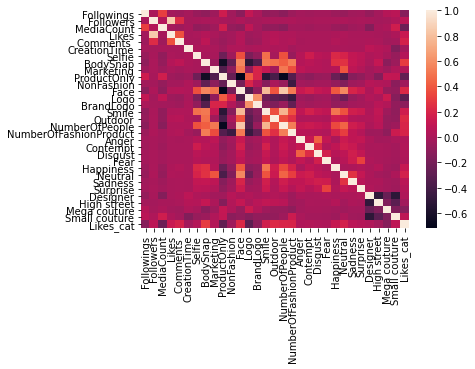

In [198]:
import seaborn as sns
corr = data_ver2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
# sns.plt.show()

In [207]:
y_test_binary.argmax(axis=1)

array([1, 3, 1, ..., 3, 3, 0])

In [208]:
preds_cat.round().argmax(axis=1)

array([3, 0, 0, ..., 3, 3, 0])

In [203]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_binary.argmax(axis=1), preds_cat.round().argmax(axis=1))
print(cm)

[[3866   35    3   26]
 [1075 6699   21   83]
 [ 971   37 5284  152]
 [ 686   23   28 4673]]


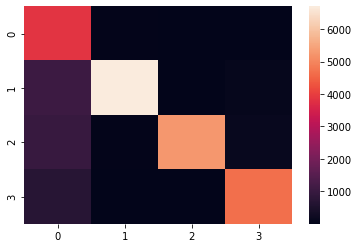

In [206]:
sns.heatmap(cm)